In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# make path = './' in-case you are running this locally
path = '/content/drive/My Drive/ECSE416_ComputerVision/A4/'
print(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECSE416_ComputerVision/A4/


# 1. Image Segmentation using K-means

In [ ]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

# load the image covert colour and change to a float then print dimentions
home = cv2.imread(path+"images/home.jpg")
home = cv2.cvtColor(home, cv2.COLOR_BGR2RGB)
home = np.float32(home)

# Kmeans algorithm from scrath n= numberr of iterations
def Kmeans (home, K, n):
  width, height, channel = home.shape
  home_resize = home.reshape(-1,channel) 
  home_resize = np.float32(home_resize) #data points of home image

  # Create random arrray and assign them as K centers 
  randarr = np.random.randint(width*height, size=K)
  Kcenter = home_resize[randarr]

  # place points to the nearest cluster
  zeroarr = np.zeros([width*height, K], dtype=np.float64)
  
  cluster_n = []
  # Calculating distance to center to assign clusters and calculate a new mean and adjust centters
  for i in range(n):
    for j,k in enumerate(Kcenter):
      zeroarr[:, j] = distance(k, home_resize)
    mean0 = np.argmin(zeroarr, axis=1)
    for l in range(K):
      Kcenter[l] = np.mean(home_resize[mean0 == l],0)

    # Store iterations
    Kcenter_temp = Kcenter.astype("uint8") # convert back
    cluster_temp = Kcenter_temp[mean0.flatten()]
    if(channel>1):
        cluster_temp = cluster_temp.reshape(width, height, channel)
    else:
        cluster_temp = cluster_temp.reshape(width, height)
    cluster_n.append(cluster_temp)

  Kcenter = Kcenter.astype("uint8") # convert back

  # get the clusters
  cluster = Kcenter[mean0.flatten()]
  if(channel==1):
      cluster = cluster.reshape((width, height))
  else:
      cluster = cluster.reshape((width, height, channel))
  return cluster_n

# Calculating the distance between the center and the data points
def distance(Kcenter,pt):
  return np.linalg.norm(pt - Kcenter, axis=1)
   


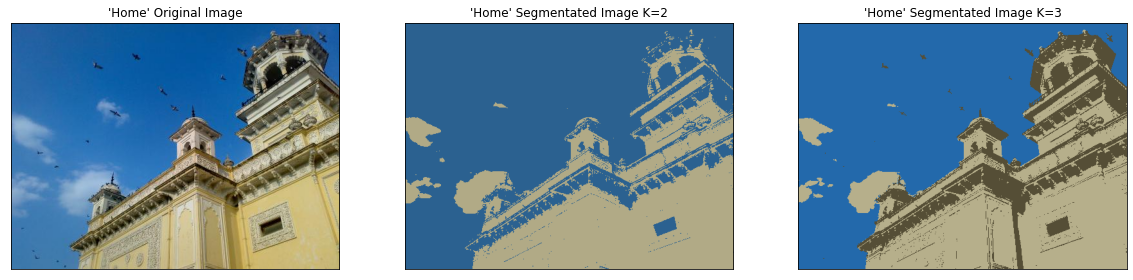

In [ ]:
# load the 'home' image 
home = cv2.imread(path+"images/home.jpg")
home = cv2.cvtColor(home, cv2.COLOR_BGR2RGB)

# apply K means to the image where K = 2 and K = 3
home_K2 = Kmeans(home, K=2, n=10)
home_K3 = Kmeans(home, K=3, n=10)

# Get the segmented image from the 10th iteration for K=2 and K = 3
home_K2_final = home_K2[len(home_K2)-1]
home_K3_final = home_K3[len(home_K3)-1]

# display the images
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(home)
plt.title("'Home' Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(home_K2_final)
plt.title("'Home' Segmentated Image K=2"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(home_K3_final)
plt.title("'Home' Segmentated Image K=3"), plt.xticks([]), plt.yticks([])
plt.show()

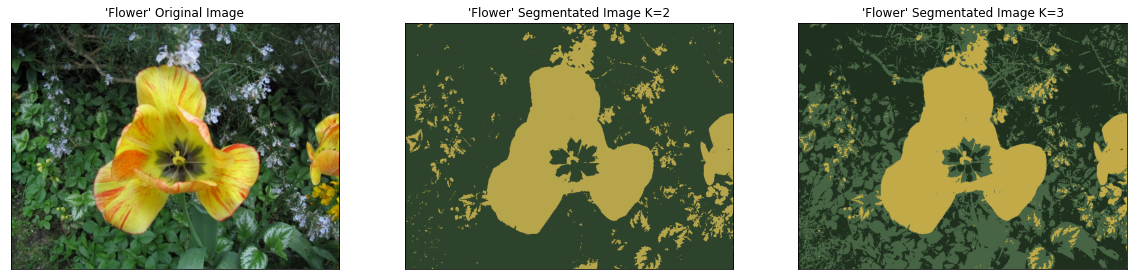

In [ ]:
# load the'flower' image 
flower = cv2.imread(path+"images/flower.jpg")
flower = cv2.cvtColor(flower, cv2.COLOR_BGR2RGB)

# apply K means to the image where K = 2 and K = 3
flower_K2 = Kmeans(flower, K=2, n=10)
flower_K3 = Kmeans(flower, K=3, n=10)

# Get the segmented image from the 10th iteration for K=2 and K = 3
flower_K2_final = flower_K2[len(flower_K2)-1]
flower_K3_final = flower_K3[len(flower_K3)-1]

# display the images
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(flower)
plt.title("'Flower' Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(flower_K2_final)
plt.title("'Flower' Segmentated Image K=2"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(flower_K3_final)
plt.title("'Flower' Segmentated Image K=3"), plt.xticks([]), plt.yticks([])
plt.show()

# 2. Disparity

In [ ]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

Dimentions:  (333, 385)


(Text(0.5, 1.0, 'Right Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

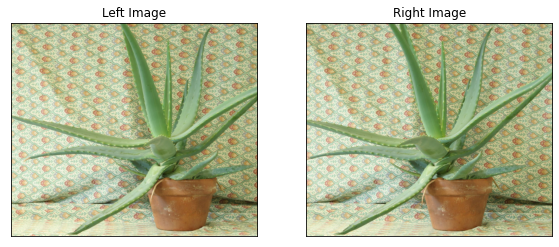

In [85]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture

# Resize the images, check 
# load left and right images and convert to grayscale (0,255)
aloeL = cv2.imread(path+"images/aloeL.jpg")
aloeR = cv2.imread(path+"images/aloeR.jpg")
aloeL_G = cv2.cvtColor(aloeL, cv2.COLOR_BGR2GRAY)
aloeR_G = cv2.cvtColor(aloeR, cv2.COLOR_BGR2GRAY)

# resize the image
aloeL_G_R = (cv2.resize(aloeL_G, None, fx=0.3, fy=0.3)).astype("int32");
aloeR_G_R = (cv2.resize(aloeR_G, None, fx=0.3, fy=0.3)).astype("int32");

print("Dimentions: ",aloeL_G_R.shape)

# extract a 5x5 window centered st each pixel of the left image
rowL, colL = aloeL_G_R.shape

# create an array of zeros in the dimentions of the resized image
disparity = np.zeros((rowL,colL))

# create a sliding window of size 5x5 and set dispart to 48 outside the boundary 
for i in range(rowL):
    for j in range(colL):
      windowref = aloeL_G_R[i-2:i+2+1,j-2:j+2+1]
      if windowref.shape != (5,5):
        windowref = np.full((5, 5), -1)
      if windowref.shape != (5,5):
        disparity = 48
      if j-47<0:
        disparity = 48
      
       # create a scanline
      for x in range(j,j-47,-1):
        window_R = aloeR_G_R[i-2:i+2+1,j-2:j+2+1]
        if window_R.shape != (5,5):
          window_R = np.full((5, 5), -1)
      
        # compute the SSD 
        window = windowref - window_R
        windowSQ = np.square(window)
        SSD = np.sum(windowSQ.ravel())

      # compute the disparity map
      # find the min SSD
      disparity = np.argmin(SSD)

# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(cv2.cvtColor(aloeL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(aloeR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
# plt.subplot(133), plt.imshow(disparity, cmap="gray_r")
# plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])


# 3. Optical Flow

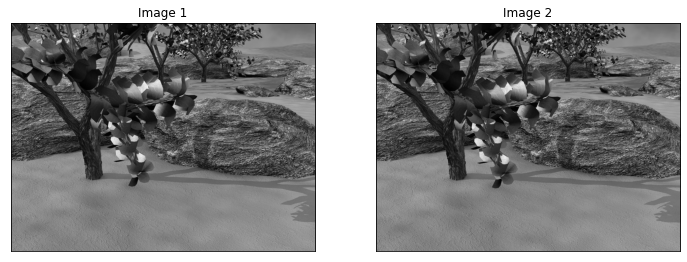

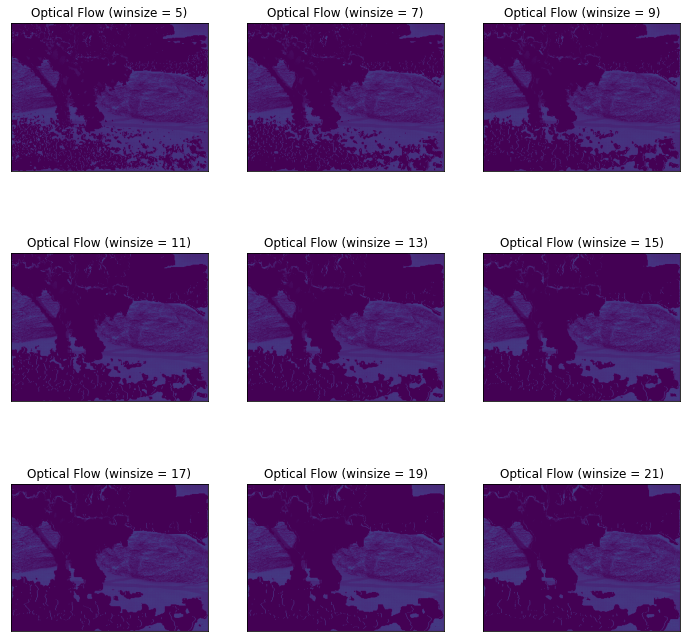

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# A function to help draw optical flow with flow lines
def draw_flow(img, flow, step=16): #is the step here suppose to be 16 or 2
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img.copy()#cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# load the images and convert to grayscale
frame10 = cv2.imread(path+"images/frame10.png")
frame11 = cv2.imread(path+"images/frame11.png")

frame10_G = cv2.cvtColor(frame10, cv2.COLOR_BGR2GRAY)
frame11_G = cv2.cvtColor(frame11, cv2.COLOR_BGR2GRAY)

# Compute optical flow using the Gunner Farneback's algorithm
flow5 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=5, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow7 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow9 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=9, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow11 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=11, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow13 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=13, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow15 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow17 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=17, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow19 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=19, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow21 = cv2.calcOpticalFlowFarneback(prev=frame10_G, next=frame11_G, flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=21, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# draw flow
vis5 = draw_flow(frame10_G, flow5, step=2)
vis7 = draw_flow(frame10_G, flow7, step=2)
vis9 = draw_flow(frame10_G, flow9, step=2)
vis11 = draw_flow(frame10_G, flow11, step=2)
vis13 = draw_flow(frame10_G, flow13, step=2)
vis15 = draw_flow(frame10_G, flow15, step=2)
vis17 = draw_flow(frame10_G, flow17, step=2)
vis19 = draw_flow(frame10_G, flow19, step=2)
vis21 = draw_flow(frame10_G, flow21, step=2)

# display images
plt.figure(figsize=(12,12))
plt.subplot(221), plt.imshow(cv2.cvtColor(frame10_G, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(cv2.cvtColor(frame11_G, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(12,12))
plt.subplot(331),plt.imshow(vis5)
plt.title("Optical Flow (winsize = 5)"), plt.xticks([]), plt.yticks([])
plt.subplot(332),plt.imshow(vis7)
plt.title("Optical Flow (winsize = 7)"), plt.xticks([]), plt.yticks([])
plt.subplot(333),plt.imshow(vis9)
plt.title("Optical Flow (winsize = 9)"), plt.xticks([]), plt.yticks([])
plt.subplot(334),plt.imshow(vis11)
plt.title("Optical Flow (winsize = 11)"), plt.xticks([]), plt.yticks([])
plt.subplot(335),plt.imshow(vis13)
plt.title("Optical Flow (winsize = 13)"), plt.xticks([]), plt.yticks([])
plt.subplot(336),plt.imshow(vis15)
plt.title("Optical Flow (winsize = 15)"), plt.xticks([]), plt.yticks([])
plt.subplot(337),plt.imshow(vis17)
plt.title("Optical Flow (winsize = 17)"), plt.xticks([]), plt.yticks([])
plt.subplot(338),plt.imshow(vis19)
plt.title("Optical Flow (winsize = 19)"), plt.xticks([]), plt.yticks([])
plt.subplot(339),plt.imshow(vis21)
plt.title("Optical Flow (winsize = 21)"), plt.xticks([]), plt.yticks([])
plt.show()

(480, 640, 2)
(480, 1280)
(480, 1280)


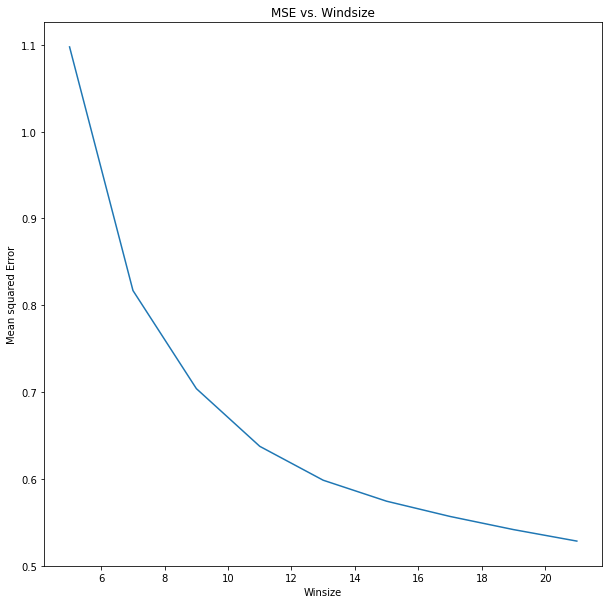

In [ ]:
from sklearn.metrics import mean_squared_error

# load ground truth and find size
gt = np.load(path+"images/flow10.npz")["flow"] 
print(gt.shape)
flow5 = flow5.reshape(480,-1)
flow7 = flow7.reshape(480,-1)
flow9 = flow9.reshape(480,-1)
flow11 = flow11.reshape(480,-1)
flow13 = flow13.reshape(480,-1)
flow15 = flow15.reshape(480,-1)
flow17 = flow17.reshape(480,-1)
flow19 = flow19.reshape(480,-1)
flow21 = flow21.reshape(480,-1)
gt = gt.reshape(480,-1)
print(flow5.shape)
print(gt.shape)

# mean squared error between estimated optical flow and the ground truth optical flow 
MSE5 = mean_squared_error(flow5, gt)
MSE7 = mean_squared_error(flow7, gt)
MSE9 = mean_squared_error(flow9, gt)
MSE11 = mean_squared_error(flow11, gt)
MSE13 = mean_squared_error(flow13, gt)
MSE15 = mean_squared_error(flow15, gt)
MSE17 = mean_squared_error(flow17, gt)
MSE19 = mean_squared_error(flow19, gt)
MSE21 = mean_squared_error(flow21, gt)

# # Plot MSE vs Windsize
plt.figure(figsize=(10,10))
plt.plot([5,7,9,11,13,15,17,19,21], [MSE5,MSE7,MSE9,MSE11,MSE13,MSE15,MSE17,MSE19,MSE21])
plt.title("MSE vs. Windsize")
plt.xlabel("Winsize")
plt.ylabel("Mean squared Error")
plt.show()

Do you observe any trend in the plot above? Does the error increase or decrease with increasing window-size? Explain the effect of window-size on the prediction error.

*The error decreases as the winsize increases. The *